# Computational Finance and Financial Management


## Time-series analysis, replication and forecasting of the German TecDAX stock index

By Merlin Bartel and Max Veltwisch

Trying to predict the stock market is an enticing prospect to us, not so much as a desire for material gain, but for the challenge. Already in 1965 the Economist and Nobel Price winner Paul Samuelson postulated in his influencial paper: "Properly Anticipated Prices Fluctuate Randomly" that returns of the past have no prediction power for future returns. He concluded that market prices could be considered a Martingale. This implies that the analysis and knownledge of historical price development is of no use for future price predictions. Nevertheless by looking at the daily up and downs of the market, we imagine there must be patterns we can model to beat all odds. Our analysis follows three main sections:

1. Exploratory analysis on the TecDAX Index price data
2. Applied Deep-Learning method to predict stock weights of the TecDAX index.
3. Forecasting the TecDAX price development using the Facebook Prophet model.
4. Forecasting the TecDAX price development using a LSTM model approach.

The first section serves the goal to better understand the general structure and charateristics of the historical TecDAX Index price development. Section two differs from the following sections by trying to estimate the weights of the stocks contained in the TecDAX Index in a way that replication becomes as precise as possible. The following sections make use of different model approaches with the goal of recognising patterns in the historical price movements of the TecDAX Index and using them to forecast future Index Prices.


Before we start with our research we load the required python packeges into our environment.

In [1]:
#loading required packages
import math
import pylab
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime
from datetime import timedelta

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

import statistics
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy import special, optimize

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.



## Exploratory analysis on the TecDAX index price data

We first want to analyse patterns and characteristics in the historically realized price development of the TecDAX Index. We are looking at the adjusted close prices of the TecDax Index from 01.01.2007 till 01.06.2019. The source of the TecDAX dataset and all following datasets is: finance.yahoo.com.

In [2]:
# importing TecDAX Index price data
TecDAX = pd.read_csv("TECDAX.csv", index_col=0, parse_dates=True, squeeze=True)
# extracting adjusted close prices (variable of interest)
TecDAX = TecDAX["Adj Close"]

In [3]:
# showing general statisitcal values
TecDAX.describe()

count    3143.000000
mean     1309.951536
std       686.404890
min       405.140015
25%       790.734985
50%       956.710022
75%      1725.950012
max      3039.479980
Name: Adj Close, dtype: float64

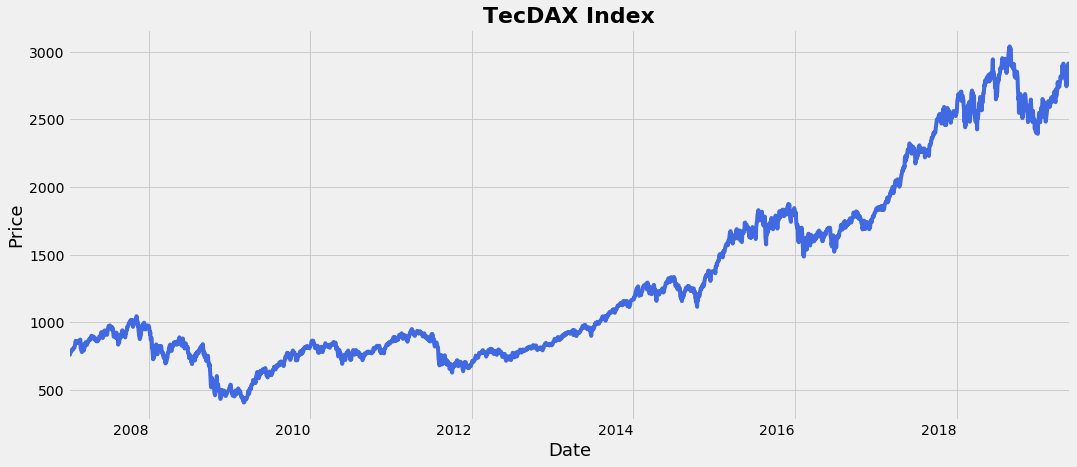

In [4]:
# plotting historical price movement
plt.style.use('fivethirtyeight')
TecDAX.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.title("TecDAX Index",fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

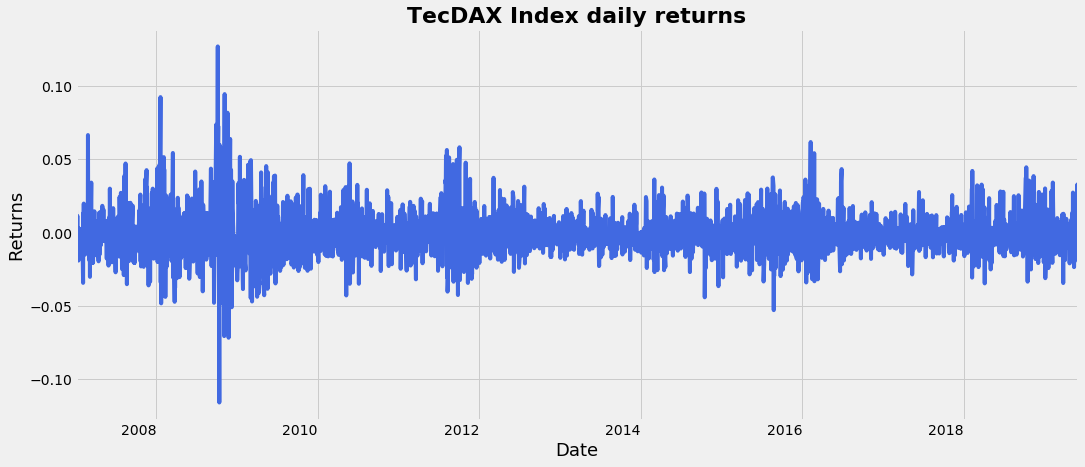

In [5]:
# calculating the daily returns
daily_returns = TecDAX.shift(1) / TecDAX - 1

# visualising the daily returns
daily_returns.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel("Returns",fontsize=18,color='black')
plt.title("TecDAX Index daily returns", fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

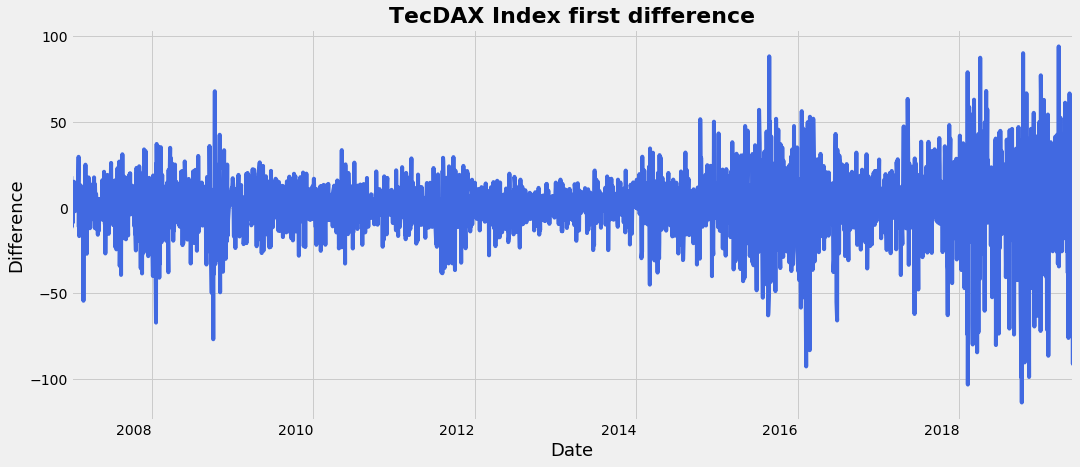

In [6]:
# computing the first-difference
training_diff = TecDAX.diff()

# visualising first-difference
training_diff.plot(figsize=(16,8), color='royalblue')
plt.xlabel("Date",fontsize=18,color='black')
plt.ylabel("Difference",fontsize=18,color='black')
plt.title("TecDAX Index first difference", fontweight='bold',fontsize=22)
plt.xticks(rotation=0)

plt.show()

# Applied Deep-Learning method to predict stock weights of the TecDAX index. 


In [13]:
# importing the data
data = pd.read_csv("Alltogether.csv", encoding='latin-1')
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)  

# extracting adjusted close prices (variable of interest)
y = data["TecDAX"]
y = y.values.reshape(len(y),1)
x = data.iloc [0:,1:]
x = x.values.reshape(len(y),41)

train_size = 985
test_size  = len(y) - train_size
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train, x_test = x[0:train_size,:], x[train_size:len(y),:]


test_size

7

In [8]:
# building the neural network
def index_model(n_first):
    model = Sequential()
    # input layer
    model.add(Dense(n_first,activation='linear',input_dim=x_train.shape[1])) 
    # output layer
    model.add(Dense(1)) # Since default activation function is linear, no need to define compilation
    model.compile(optimizer='Adagrad',loss='mean_absolute_error')
    return model

In [9]:
# creating a dataframe object to store first_hidden and rmse
result = pd.DataFrame(columns=['first_hidden','rmse'])
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 2 columns):
first_hidden    0 non-null object
rmse            0 non-null object
dtypes: object(2)
memory usage: 0.0+ bytes


In [10]:
#  !! fitting the model can take significant amount of time and computation power !!

# using for-loop to run combinations
for first_layer in [40,500]:
            model = index_model(first_layer)
            # training the neural network, validation set is included to check if overfitting occurs
            model.fit(x_train, y_train, epochs=1000)
            # geting the performance by using validaiton set 
            rmse = model.evaluate(x_train, y_train)
            result = result.append({'first_hidden':first_layer,'rmse':rmse},ignore_index=True)
            

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/1000
985/985 [==============================] - 0s 184us/step - loss: 1207.8286
Epoch 2/1000
985/985 [==============================] - 0s 36us/step - loss: 81.1951
Epoch 3/1000
985/985 [==============================] - 0s 37us/step - loss: 31.2579
Epoch 4/1000
985/985 [==============================] - 0s 42us/step - loss: 30.4515
Epoch 5/1000
985/985 [==============================] - 0s 46us/step - loss: 29.8340
Epoch 6/1000
985/985 [==============================] - 0s 43us/step - loss: 28.7261
Epoch 7/1000
985/985 [==============================] - 0s 46us/step - loss: 28.0508
Epoch 8/1000
985/985 [==============================] - 0s 62us/step - loss: 27.9428
Epoch 9/1000
985/985 [==============================] - 0s 71us/step - loss: 27.1728
Epoch 10/1000
985/985 [==============================] - 0s 72us/step - loss: 26.1761
Epoch 11/1000
985/985 [==============================] - 0s 51us/step - loss: 26.2918
Epoch 12/1000
985/985 [==============================] - 0s 

985/985 [==============================] - 0s 43us/step - loss: 12.7335
Epoch 191/1000
985/985 [==============================] - 0s 44us/step - loss: 12.7292
Epoch 192/1000
985/985 [==============================] - 0s 48us/step - loss: 12.6650
Epoch 193/1000
985/985 [==============================] - 0s 65us/step - loss: 12.6816
Epoch 194/1000
985/985 [==============================] - 0s 60us/step - loss: 12.6578
Epoch 195/1000
985/985 [==============================] - 0s 46us/step - loss: 12.5790
Epoch 196/1000
985/985 [==============================] - 0s 50us/step - loss: 12.8036
Epoch 197/1000
985/985 [==============================] - 0s 57us/step - loss: 12.6216
Epoch 198/1000
985/985 [==============================] - 0s 76us/step - loss: 12.6108
Epoch 199/1000
985/985 [==============================] - 0s 46us/step - loss: 12.6283
Epoch 200/1000
985/985 [==============================] - 0s 47us/step - loss: 12.5553
Epoch 201/1000
985/985 [==============================] - 

985/985 [==============================] - 0s 33us/step - loss: 11.2537
Epoch 285/1000
985/985 [==============================] - 0s 34us/step - loss: 11.3379
Epoch 286/1000
985/985 [==============================] - 0s 36us/step - loss: 11.3093
Epoch 287/1000
985/985 [==============================] - 0s 36us/step - loss: 11.3799
Epoch 288/1000
985/985 [==============================] - 0s 40us/step - loss: 11.1675
Epoch 289/1000
985/985 [==============================] - 0s 53us/step - loss: 11.1745
Epoch 290/1000
985/985 [==============================] - 0s 82us/step - loss: 11.2270
Epoch 291/1000
985/985 [==============================] - 0s 80us/step - loss: 11.1274
Epoch 292/1000
985/985 [==============================] - 0s 49us/step - loss: 11.1413
Epoch 293/1000
985/985 [==============================] - 0s 48us/step - loss: 11.0899
Epoch 294/1000
985/985 [==============================] - 0s 40us/step - loss: 11.1450
Epoch 295/1000
985/985 [==============================] - 

985/985 [==============================] - 0s 36us/step - loss: 9.5659
Epoch 474/1000
985/985 [==============================] - 0s 38us/step - loss: 9.5092
Epoch 475/1000
985/985 [==============================] - 0s 37us/step - loss: 9.6893
Epoch 476/1000
985/985 [==============================] - 0s 37us/step - loss: 9.6755
Epoch 477/1000
985/985 [==============================] - 0s 39us/step - loss: 9.5204
Epoch 478/1000
985/985 [==============================] - 0s 39us/step - loss: 9.6187
Epoch 479/1000
985/985 [==============================] - 0s 34us/step - loss: 9.4859
Epoch 480/1000
985/985 [==============================] - 0s 36us/step - loss: 9.5661
Epoch 481/1000
985/985 [==============================] - 0s 35us/step - loss: 9.5971
Epoch 482/1000
985/985 [==============================] - 0s 36us/step - loss: 9.4485
Epoch 483/1000
985/985 [==============================] - 0s 36us/step - loss: 9.5413
Epoch 484/1000
985/985 [==============================] - 0s 44us/ste

985/985 [==============================] - 0s 35us/step - loss: 8.5518
Epoch 664/1000
985/985 [==============================] - 0s 37us/step - loss: 8.5528
Epoch 665/1000
985/985 [==============================] - 0s 36us/step - loss: 8.5257
Epoch 666/1000
985/985 [==============================] - 0s 34us/step - loss: 8.4936
Epoch 667/1000
985/985 [==============================] - 0s 34us/step - loss: 8.4588
Epoch 668/1000
985/985 [==============================] - 0s 35us/step - loss: 8.5767
Epoch 669/1000
985/985 [==============================] - 0s 41us/step - loss: 8.5698
Epoch 670/1000
985/985 [==============================] - 0s 34us/step - loss: 8.4837
Epoch 671/1000
985/985 [==============================] - 0s 35us/step - loss: 8.5644
Epoch 672/1000
985/985 [==============================] - 0s 36us/step - loss: 8.5520
Epoch 673/1000
985/985 [==============================] - 0s 38us/step - loss: 8.5388
Epoch 674/1000
985/985 [==============================] - 0s 36us/ste

985/985 [==============================] - 0s 37us/step - loss: 7.8769
Epoch 854/1000
985/985 [==============================] - 0s 39us/step - loss: 7.9287
Epoch 855/1000
985/985 [==============================] - 0s 37us/step - loss: 7.9569
Epoch 856/1000
985/985 [==============================] - 0s 36us/step - loss: 7.8969
Epoch 857/1000
985/985 [==============================] - 0s 36us/step - loss: 7.9092
Epoch 858/1000
985/985 [==============================] - 0s 38us/step - loss: 7.9895
Epoch 859/1000
985/985 [==============================] - 0s 37us/step - loss: 7.9007
Epoch 860/1000
985/985 [==============================] - 0s 37us/step - loss: 7.8639
Epoch 861/1000
985/985 [==============================] - 0s 39us/step - loss: 7.9036
Epoch 862/1000
985/985 [==============================] - 0s 39us/step - loss: 7.8481
Epoch 863/1000
985/985 [==============================] - 0s 38us/step - loss: 7.8395
Epoch 864/1000
985/985 [==============================] - 0s 36us/ste

985/985 [==============================] - 0s 41us/step - loss: 16.7769
Epoch 43/1000
985/985 [==============================] - 0s 41us/step - loss: 18.6969
Epoch 44/1000
985/985 [==============================] - 0s 41us/step - loss: 18.1116
Epoch 45/1000
985/985 [==============================] - 0s 40us/step - loss: 16.6073
Epoch 46/1000
985/985 [==============================] - 0s 46us/step - loss: 16.0303
Epoch 47/1000
985/985 [==============================] - 0s 39us/step - loss: 16.2099
Epoch 48/1000
985/985 [==============================] - 0s 40us/step - loss: 15.7471
Epoch 49/1000
985/985 [==============================] - 0s 40us/step - loss: 15.5475
Epoch 50/1000
985/985 [==============================] - 0s 39us/step - loss: 16.2528
Epoch 51/1000
985/985 [==============================] - 0s 45us/step - loss: 16.5117
Epoch 52/1000
985/985 [==============================] - 0s 40us/step - loss: 16.2157
Epoch 53/1000
985/985 [==============================] - 0s 41us/ste

Epoch 137/1000
985/985 [==============================] - 0s 45us/step - loss: 10.9849
Epoch 138/1000
985/985 [==============================] - 0s 41us/step - loss: 12.0004
Epoch 139/1000
985/985 [==============================] - 0s 42us/step - loss: 12.0382
Epoch 140/1000
985/985 [==============================] - 0s 46us/step - loss: 12.4069
Epoch 141/1000
985/985 [==============================] - 0s 42us/step - loss: 11.0915
Epoch 142/1000
985/985 [==============================] - 0s 41us/step - loss: 11.3449
Epoch 143/1000
985/985 [==============================] - 0s 42us/step - loss: 11.6462
Epoch 144/1000
985/985 [==============================] - 0s 42us/step - loss: 11.0454
Epoch 145/1000
985/985 [==============================] - 0s 39us/step - loss: 11.3296
Epoch 146/1000
985/985 [==============================] - 0s 42us/step - loss: 11.7620
Epoch 147/1000
985/985 [==============================] - 0s 44us/step - loss: 10.7861
Epoch 148/1000
985/985 [===================

985/985 [==============================] - 0s 42us/step - loss: 8.0881
Epoch 327/1000
985/985 [==============================] - 0s 44us/step - loss: 9.1803
Epoch 328/1000
985/985 [==============================] - 0s 43us/step - loss: 8.1401
Epoch 329/1000
985/985 [==============================] - 0s 40us/step - loss: 8.7419
Epoch 330/1000
985/985 [==============================] - 0s 43us/step - loss: 9.0969
Epoch 331/1000
985/985 [==============================] - 0s 41us/step - loss: 8.0871
Epoch 332/1000
985/985 [==============================] - 0s 43us/step - loss: 8.8500
Epoch 333/1000
985/985 [==============================] - 0s 43us/step - loss: 8.0561
Epoch 334/1000
985/985 [==============================] - 0s 44us/step - loss: 8.5473
Epoch 335/1000
985/985 [==============================] - 0s 42us/step - loss: 8.4396
Epoch 336/1000
985/985 [==============================] - 0s 43us/step - loss: 8.3560
Epoch 337/1000
985/985 [==============================] - 0s 47us/ste

985/985 [==============================] - 0s 46us/step - loss: 7.5149
Epoch 517/1000
985/985 [==============================] - 0s 48us/step - loss: 7.7777
Epoch 518/1000
985/985 [==============================] - 0s 43us/step - loss: 7.0799
Epoch 519/1000
985/985 [==============================] - 0s 43us/step - loss: 7.4471
Epoch 520/1000
985/985 [==============================] - 0s 43us/step - loss: 7.7993
Epoch 521/1000
985/985 [==============================] - 0s 40us/step - loss: 7.5960
Epoch 522/1000
985/985 [==============================] - 0s 42us/step - loss: 7.9299
Epoch 523/1000
985/985 [==============================] - 0s 42us/step - loss: 7.3223
Epoch 524/1000
985/985 [==============================] - 0s 43us/step - loss: 7.3879
Epoch 525/1000
985/985 [==============================] - 0s 42us/step - loss: 7.6536
Epoch 526/1000
985/985 [==============================] - 0s 42us/step - loss: 7.7304
Epoch 527/1000
985/985 [==============================] - 0s 42us/ste

985/985 [==============================] - 0s 48us/step - loss: 6.8860
Epoch 707/1000
985/985 [==============================] - 0s 46us/step - loss: 6.7387
Epoch 708/1000
985/985 [==============================] - 0s 47us/step - loss: 6.7029
Epoch 709/1000
985/985 [==============================] - 0s 62us/step - loss: 6.7877
Epoch 710/1000
985/985 [==============================] - 0s 44us/step - loss: 6.9064
Epoch 711/1000
985/985 [==============================] - 0s 40us/step - loss: 6.6134
Epoch 712/1000
985/985 [==============================] - 0s 50us/step - loss: 6.9360
Epoch 713/1000
985/985 [==============================] - 0s 48us/step - loss: 6.9396
Epoch 714/1000
985/985 [==============================] - 0s 49us/step - loss: 6.6529
Epoch 715/1000
985/985 [==============================] - 0s 65us/step - loss: 6.9223
Epoch 716/1000
985/985 [==============================] - 0s 85us/step - loss: 6.7995
Epoch 717/1000
985/985 [==============================] - 0s 69us/ste

985/985 [==============================] - 0s 46us/step - loss: 6.6597
Epoch 897/1000
985/985 [==============================] - 0s 46us/step - loss: 6.5983
Epoch 898/1000
985/985 [==============================] - 0s 43us/step - loss: 6.4710
Epoch 899/1000
985/985 [==============================] - 0s 47us/step - loss: 6.8320
Epoch 900/1000
985/985 [==============================] - 0s 50us/step - loss: 6.3233
Epoch 901/1000
985/985 [==============================] - 0s 49us/step - loss: 6.2725
Epoch 902/1000
985/985 [==============================] - 0s 43us/step - loss: 6.2960
Epoch 903/1000
985/985 [==============================] - 0s 45us/step - loss: 6.6564
Epoch 904/1000
985/985 [==============================] - 0s 54us/step - loss: 6.2638
Epoch 905/1000
985/985 [==============================] - 0s 49us/step - loss: 6.6243
Epoch 906/1000
985/985 [==============================] - 0s 51us/step - loss: 6.8104
Epoch 907/1000
985/985 [==============================] - 0s 54us/ste

In [11]:
# showing first_hidden and rmse
result

,first_hidden,rmse
0,40.0,7.499907
1,500.0,5.925185


In [12]:
# using idxmin() function to check which combination provides the minimized rmse 
min_index = result['rmse'].idxmin()
print(min_index)

1


In [13]:
first_hidden_best = result['first_hidden'][min_index]

In [14]:
#  !! fitting the model can take significant amount of time and computation power !!

# transforming float back to integer
first_hidden_best  = int(first_hidden_best)

# training the model again
min_model = index_model(first_hidden_best)
min_model.fit(x_train, y_train, epochs=1000)
min_rmse = min_model.evaluate(x_test, y_test)

print("Mean absolute Error for the test set: ", min_rmse)

Epoch 1/1000
985/985 [==============================] - 0s 219us/step - loss: 314.4151
Epoch 2/1000
985/985 [==============================] - 0s 49us/step - loss: 52.4920
Epoch 3/1000
985/985 [==============================] - 0s 44us/step - loss: 47.1563
Epoch 4/1000
985/985 [==============================] - 0s 51us/step - loss: 40.9081
Epoch 5/1000
985/985 [==============================] - 0s 53us/step - loss: 32.8380
Epoch 6/1000
985/985 [==============================] - 0s 56us/step - loss: 34.4714
Epoch 7/1000
985/985 [==============================] - 0s 60us/step - loss: 31.4823
Epoch 8/1000
985/985 [==============================] - 0s 63us/step - loss: 30.4024
Epoch 9/1000
985/985 [==============================] - 0s 50us/step - loss: 29.4704
Epoch 10/1000
985/985 [==============================] - 0s 44us/step - loss: 28.2677
Epoch 11/1000
985/985 [==============================] - 0s 46us/step - loss: 26.7142
Epoch 12/1000
985/985 [==============================] - 0s 4

985/985 [==============================] - 0s 41us/step - loss: 10.4624
Epoch 191/1000
985/985 [==============================] - 0s 52us/step - loss: 10.5052
Epoch 192/1000
985/985 [==============================] - 0s 42us/step - loss: 10.6556
Epoch 193/1000
985/985 [==============================] - 0s 41us/step - loss: 10.0881
Epoch 194/1000
985/985 [==============================] - 0s 41us/step - loss: 10.1397
Epoch 195/1000
985/985 [==============================] - 0s 42us/step - loss: 10.1669
Epoch 196/1000
985/985 [==============================] - 0s 40us/step - loss: 10.7500
Epoch 197/1000
985/985 [==============================] - 0s 40us/step - loss: 10.8314
Epoch 198/1000
985/985 [==============================] - 0s 40us/step - loss: 10.0072
Epoch 199/1000
985/985 [==============================] - 0s 40us/step - loss: 10.5614
Epoch 200/1000
985/985 [==============================] - 0s 41us/step - loss: 11.0017
Epoch 201/1000
985/985 [==============================] - 

985/985 [==============================] - 0s 41us/step - loss: 8.9612
Epoch 286/1000
985/985 [==============================] - 0s 42us/step - loss: 8.7802
Epoch 287/1000
985/985 [==============================] - 0s 48us/step - loss: 9.3410
Epoch 288/1000
985/985 [==============================] - 0s 41us/step - loss: 9.2318
Epoch 289/1000
985/985 [==============================] - 0s 40us/step - loss: 9.2162
Epoch 290/1000
985/985 [==============================] - 0s 40us/step - loss: 8.8707
Epoch 291/1000
985/985 [==============================] - 0s 41us/step - loss: 8.6187
Epoch 292/1000
985/985 [==============================] - 0s 39us/step - loss: 8.9218
Epoch 293/1000
985/985 [==============================] - 0s 41us/step - loss: 8.9168
Epoch 294/1000
985/985 [==============================] - 0s 41us/step - loss: 8.7860
Epoch 295/1000
985/985 [==============================] - 0s 41us/step - loss: 8.8663
Epoch 296/1000
985/985 [==============================] - 0s 41us/ste

985/985 [==============================] - 0s 43us/step - loss: 7.3931
Epoch 476/1000
985/985 [==============================] - 0s 48us/step - loss: 7.6988
Epoch 477/1000
985/985 [==============================] - 0s 42us/step - loss: 7.5090
Epoch 478/1000
985/985 [==============================] - 0s 41us/step - loss: 7.9907
Epoch 479/1000
985/985 [==============================] - 0s 42us/step - loss: 7.3422
Epoch 480/1000
985/985 [==============================] - 0s 41us/step - loss: 7.8901
Epoch 481/1000
985/985 [==============================] - 0s 41us/step - loss: 7.8245
Epoch 482/1000
985/985 [==============================] - 0s 40us/step - loss: 7.8769
Epoch 483/1000
985/985 [==============================] - 0s 42us/step - loss: 7.2825
Epoch 484/1000
985/985 [==============================] - 0s 47us/step - loss: 7.7098
Epoch 485/1000
985/985 [==============================] - 0s 40us/step - loss: 7.8646
Epoch 486/1000
985/985 [==============================] - 0s 42us/ste

985/985 [==============================] - 0s 43us/step - loss: 7.1379
Epoch 666/1000
985/985 [==============================] - 0s 47us/step - loss: 6.8491
Epoch 667/1000
985/985 [==============================] - 0s 41us/step - loss: 7.0734
Epoch 668/1000
985/985 [==============================] - 0s 40us/step - loss: 7.5098
Epoch 669/1000
985/985 [==============================] - 0s 43us/step - loss: 7.2514
Epoch 670/1000
985/985 [==============================] - 0s 43us/step - loss: 7.1680
Epoch 671/1000
985/985 [==============================] - 0s 43us/step - loss: 6.8438
Epoch 672/1000
985/985 [==============================] - 0s 43us/step - loss: 6.8276
Epoch 673/1000
985/985 [==============================] - 0s 43us/step - loss: 6.8786
Epoch 674/1000
985/985 [==============================] - 0s 40us/step - loss: 7.0814
Epoch 675/1000
985/985 [==============================] - 0s 41us/step - loss: 7.1023
Epoch 676/1000
985/985 [==============================] - 0s 40us/ste

985/985 [==============================] - 0s 43us/step - loss: 6.7771
Epoch 856/1000
985/985 [==============================] - 0s 43us/step - loss: 6.8808
Epoch 857/1000
985/985 [==============================] - 0s 52us/step - loss: 6.7286
Epoch 858/1000
985/985 [==============================] - 0s 46us/step - loss: 6.6461
Epoch 859/1000
985/985 [==============================] - 0s 42us/step - loss: 6.8468
Epoch 860/1000
985/985 [==============================] - 0s 41us/step - loss: 6.8113
Epoch 861/1000
985/985 [==============================] - 0s 44us/step - loss: 6.6653
Epoch 862/1000
985/985 [==============================] - 0s 42us/step - loss: 6.5984
Epoch 863/1000
985/985 [==============================] - 0s 47us/step - loss: 6.9968
Epoch 864/1000
985/985 [==============================] - 0s 44us/step - loss: 6.6173
Epoch 865/1000
985/985 [==============================] - 0s 43us/step - loss: 6.4550
Epoch 866/1000
985/985 [==============================] - 0s 42us/ste

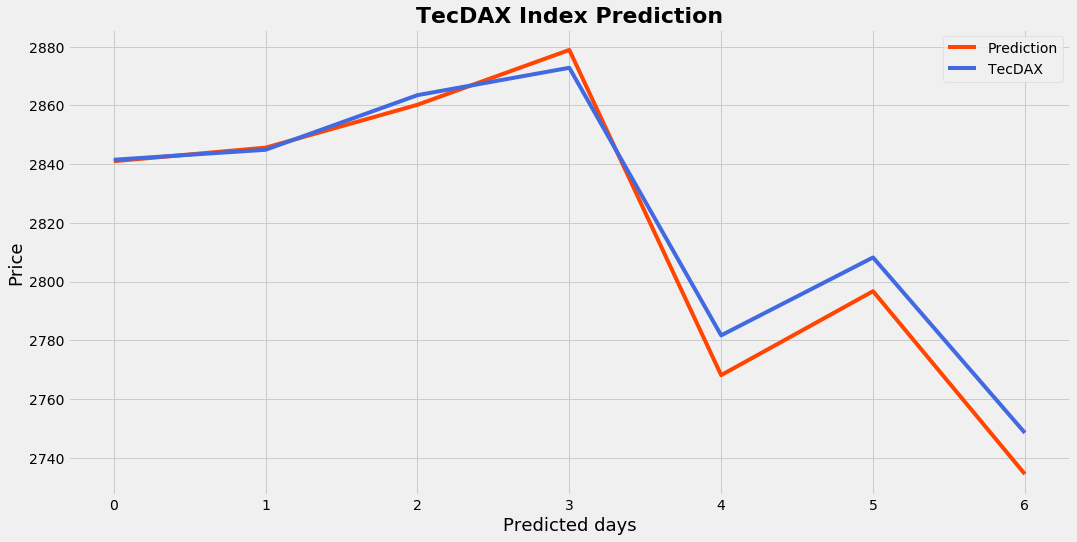

In [17]:
# visualising the results
predicted_level = model.predict(x_test)

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(predicted_level, color = 'orangered', label = 'Prediction')
plt.plot(y_test[0:,], color = 'royalblue', label = 'TecDAX')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

# Forecasting the TecDAX price development using the Facebook Prophet model.

Not all forecasting problems can be solved by the same procedure. Prophet is optimized for business forecasting tasks, which have the following characteristics: hourly, daily, or weekly observations with at least a few months (preferably multiple years) of history. At its core, the Prophet procedure is an additive regression model with three main components:

 - A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
 - A yearly seasonal component modeled using Fourier series.
 - A weekly seasonal component using dummy variables.
 
We use the TecDAX Index dataset imported in the exploratory analysis section to train the prophet model. However we will not include the year 2018 and the first half of 2019 in the training set. After training the prophet model we predict the latest 1,5 year we didnt include in the training set. The prediction results will be shown as a solid blue line with an 80% confidence intervall(light blue area). In orange color we represent the true Index price realised during the year 2018 and the first half of 2019.
 

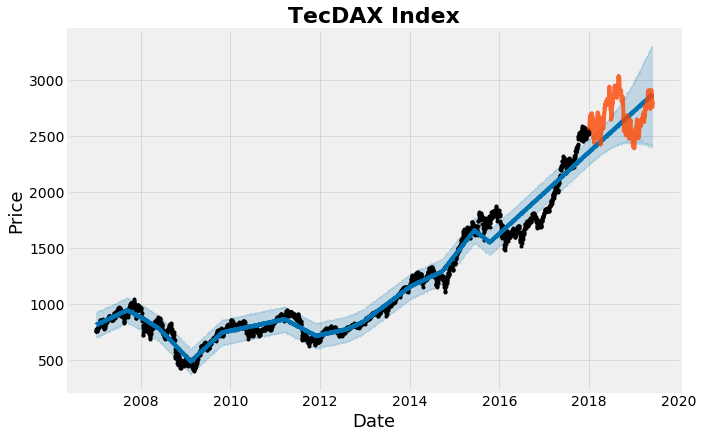

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-01-02,815.265724,705.624955,924.598236,815.265724,815.265724,2.831211,2.831211,2.831211,2.831211,2.831211,2.831211,0.0,0.0,0.0,818.096935
1,2007-01-03,815.785685,713.807978,927.549985,815.785685,815.785685,3.848236,3.848236,3.848236,3.848236,3.848236,3.848236,0.0,0.0,0.0,819.633922
2,2007-01-04,816.305647,710.092527,925.789461,816.305647,816.305647,2.655199,2.655199,2.655199,2.655199,2.655199,2.655199,0.0,0.0,0.0,818.960846
3,2007-01-05,816.825608,711.296097,929.303812,816.825608,816.825608,2.317533,2.317533,2.317533,2.317533,2.317533,2.317533,0.0,0.0,0.0,819.143141
4,2007-01-08,818.385492,706.712938,925.828773,818.385492,818.385492,-0.617902,-0.617902,-0.617902,-0.617902,-0.617902,-0.617902,0.0,0.0,0.0,817.767591
5,2007-01-09,818.905454,707.127354,929.241347,818.905454,818.905454,1.163272,1.163272,1.163272,1.163272,1.163272,1.163272,0.0,0.0,0.0,820.068726
6,2007-01-10,819.425415,714.796791,938.353289,819.425415,819.425415,2.087909,2.087909,2.087909,2.087909,2.087909,2.087909,0.0,0.0,0.0,821.513324
7,2007-01-11,819.945377,700.189095,929.500475,819.945377,819.945377,1.301520,1.301520,1.301520,1.301520,1.301520,1.301520,0.0,0.0,0.0,821.246897
8,2007-01-12,820.465338,714.554571,935.042470,820.465338,820.465338,1.699938,1.699938,1.699938,1.699938,1.699938,1.699938,0.0,0.0,0.0,822.165276
9,2007-01-15,822.025222,710.768826,937.304184,822.025222,822.025222,-1.557965,-1.557965,-1.557965,-1.557965,-1.557965,-1.557965,0.0,0.0,0.0,820.467258


In [67]:

def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    model = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    model.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    model.fit(df)
    future = model.make_future_dataframe(periods=predict_period)
    forecast = model.predict(future)
    if forecast_plot:
        model.plot(forecast)
        plt.plot(testing.index,testing.values,color='orangered',alpha=0.8)
        plt.title("TecDAX Index",fontweight='bold',fontsize=22)
        plt.xlabel('Date',fontsize=18,color='black')
        plt.ylabel('Price',fontsize=18,color='black')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    return forecast

       
cycle_analysis(TecDAX,'2018-01-02',30,forecast_plot=True,print_ind=True)


# Forecasting the TecDAX price development using a LSTM model approach.

Again we use the TecDAX Index dataset from previous sections to train the prophet model. However this time we will not include the May 2019 in the training set. After training the prophet model we predict the month May that we didnt include in the training set. The prediction results will be shown as a solid orange line. In blue color we represent the true TecDAX Index price realised during the same month.

In [15]:
# reshaping
TecDAX = TecDAX.values.reshape(len(TecDAX),1)

In [16]:
# spliting the data into train and test data
train_size = int(len(TecDAX) * 0.993)
test_size  = len(TecDAX) - train_size

TecDAX_train, TecDAX_test = TecDAX[0:train_size,:], TecDAX[train_size:len(TecDAX),:]

print("Training observations: ", len(TecDAX_train))
print("Testing observations:  ", len(TecDAX_test))

Training observations:  3120
Testing observations:   23


In [17]:
# normalizing the data
sc = MinMaxScaler(feature_range = (0, 1))

TecDAX_train.shape
training_set_scaled = sc.fit_transform(TecDAX_train)
test_set_scaled     = sc.fit_transform(TecDAX_test)

In [18]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [19]:
#  !! fitting the model can take significant amount of time and computation power !!

# initialising the RNN
regressor = Sequential()

# adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# adding the output layer
regressor.add(Dense(units = 1))
# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/100
1198/1198 [==============================] - 14s 11ms/step - loss: 0.0032
Epoch 2/100
1198/1198 [==============================] - 10s 8ms/step - loss: 6.3300e-04
Epoch 3/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.7495e-04
Epoch 4/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.7885e-04
Epoch 5/100
1198/1198 [==============================] - 10s 9ms/step - loss: 4.1795e-04
Epoch 6/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.7365e-04
Epoch 7/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.4688e-04
Epoch 8/100
1198/1198 [==============================] - 9s 8ms/step - loss: 3.6345e-04
Epoch 9/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.2373e-04
Epoch 10/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.0591e-04
Epoch 11/100
1198/1198 [==============================] - 10s 8ms/step - loss: 2.9197e-04
Epoch 12/100
1198/1198 

Epoch 92/100
1198/1198 [==============================] - 12s 10ms/step - loss: 7.5497e-05
Epoch 93/100
1198/1198 [==============================] - 16s 14ms/step - loss: 8.4059e-05
Epoch 94/100
1198/1198 [==============================] - 16s 14ms/step - loss: 7.7284e-05
Epoch 95/100
1198/1198 [==============================] - 10s 9ms/step - loss: 8.2539e-05
Epoch 96/100
1198/1198 [==============================] - 14s 12ms/step - loss: 7.4568e-05
Epoch 97/100
1198/1198 [==============================] - 13s 10ms/step - loss: 6.9116e-05
Epoch 98/100
1198/1198 [==============================] - 11s 9ms/step - loss: 7.4515e-05
Epoch 99/100
1198/1198 [==============================] - 12s 10ms/step - loss: 7.5539e-05
Epoch 100/100
1198/1198 [==============================] - 12s 10ms/step - loss: 8.1887e-05


In [21]:
# getting the predicted stock price
dataset_total = pd.concat((pd.Series(TecDAX_train[:,0]), pd.Series(TecDAX_test[:,0])), axis = 0)
inputs = dataset_total[len(dataset_total) - len(TecDAX_test) - 60:]
inputs = inputs.values.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

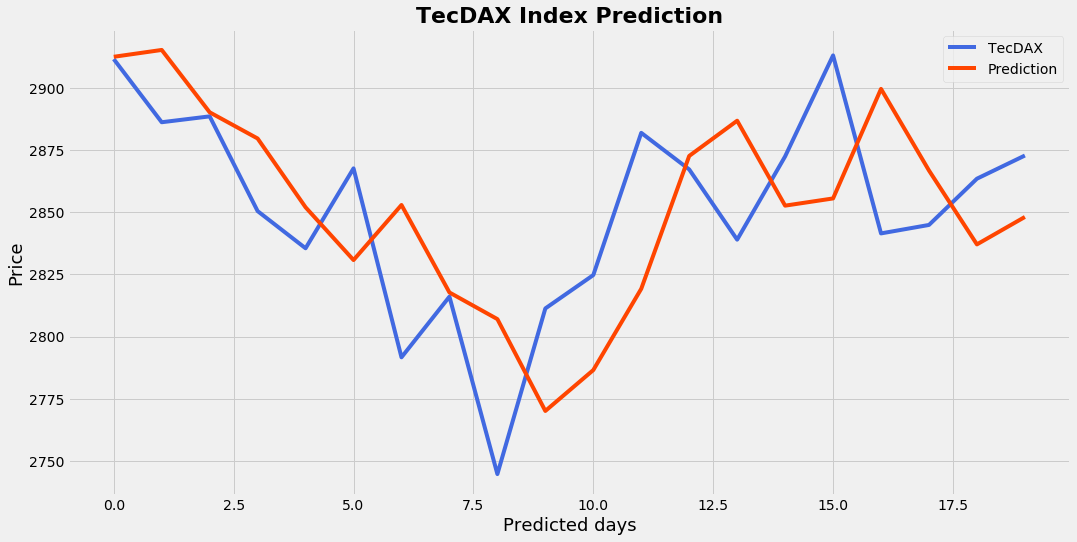

In [22]:
# Visualising the results
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(TecDAX_test[0:20,:], color = 'royalblue', label = 'TecDAX')
plt.plot(predicted_stock_price, color = 'orangered', label = 'Prediction')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()